# Interpreter


In [ ]:
# install interpret if not already installed
try:
    import interpret
except ModuleNotFoundError:
    !pip install --quiet interpret pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.5/247.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00


## LIME & SHAP

In [ ]:
!pip install --quiet shap
import shap

!pip install --quiet lime
import lime
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Libraries

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt
import sklearn
import scipy
import io
import seaborn as sns

# Sklearn
from sklearn import*
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from keras.utils import to_categorical

# For label encoding categorical data
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing

# Keras
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV



import warnings
warnings.filterwarnings('ignore')

# Explainable Boosting Machine
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from google.colab import files

# For visual representation of the Decision Tree
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

# Main

## Dataset

### Importing

In [ ]:
#@title Importing the dataset

df = pd.read_csv('/path/to/your_dataset.csv') #Place here your dataset

### Processing

In [ ]:
df.head(5)

work_year experience_level employment_type                       job_title  \
0       2021               MI              FT                  Data Scientist   
1       2021               MI              FT                 BI Data Analyst   
2       2020               MI              FT                  Data Scientist   
3       2021               MI              FT                     ML Engineer   
4       2022               SE              FT  Lead Machine Learning Engineer   

     salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0  30400000             CLP          40038                 CL           100   
1  11000000             HUF          36259                 HU            50   
2  11000000             HUF          35735                 HU            50   
3   8500000             JPY          77364                 JP            50   
4   7500000             INR          95386                 IN            50   

  company_location company_size  
0               CL            L  
1               US            L  
2               HU            L  
3               JP            S  
4               IN            L

In [ ]:
#@title Dropping unnecessary columns

# Dropping employment_type because all the entries are FT
# Dropping salary because we will use the salary_in_usd for consistency
# Dropping salary_currency because we will use the salary_in_usd conversion of the salary
df.drop(['employment_type', 'salary', 'salary_currency'], axis = 1, inplace = True)
df.head(5)

work_year experience_level                       job_title  salary_in_usd  \
0       2021               MI                  Data Scientist          40038   
1       2021               MI                 BI Data Analyst          36259   
2       2020               MI                  Data Scientist          35735   
3       2021               MI                     ML Engineer          77364   
4       2022               SE  Lead Machine Learning Engineer          95386   

  employee_residence  remote_ratio company_location company_size  
0                 CL           100               CL            L  
1                 HU            50               US            L  
2                 HU            50               HU            L  
3                 JP            50               JP            S  
4                 IN            50               IN            L

In [ ]:
#@title Creating a new column defining remote_work to 3 categories (No, Hybrid, Yes) and removing the continuous range remote_ration

df['remote_work'] = np.where(df['remote_ratio'].between(0, 20), 'No', np.where(df['remote_ratio'].between(20,80), 'Hybrid', 'Yes'))
df.loc[df['remote_work'] == 'Hybrid'].count()

df.drop('remote_ratio', axis = 1, inplace = True)
df.head(5)

work_year experience_level                       job_title  salary_in_usd  \
0       2021               MI                  Data Scientist          40038   
1       2021               MI                 BI Data Analyst          36259   
2       2020               MI                  Data Scientist          35735   
3       2021               MI                     ML Engineer          77364   
4       2022               SE  Lead Machine Learning Engineer          95386   

  employee_residence company_location company_size remote_work  
0                 CL               CL            L         Yes  
1                 HU               US            L      Hybrid  
2                 HU               HU            L      Hybrid  
3                 JP               JP            S      Hybrid  
4                 IN               IN            L      Hybrid

In [ ]:
#@title Creating a new column defining sslary to 3 categories (Low, Medium, High) and removing the continuous range remote_ration

df['salary'] = np.where(df['salary_in_usd'].between(0, 50001), 'Low', np.where(df['salary_in_usd'].between(50001,175001), 'Medium', 'High'))

df.head(5)

work_year experience_level                       job_title  salary_in_usd  \
0       2021               MI                  Data Scientist          40038   
1       2021               MI                 BI Data Analyst          36259   
2       2020               MI                  Data Scientist          35735   
3       2021               MI                     ML Engineer          77364   
4       2022               SE  Lead Machine Learning Engineer          95386   

  employee_residence company_location company_size remote_work  salary  
0                 CL               CL            L         Yes     Low  
1                 HU               US            L      Hybrid     Low  
2                 HU               HU            L      Hybrid     Low  
3                 JP               JP            S      Hybrid  Medium  
4                 IN               IN            L      Hybrid  Medium

In [ ]:
#@title Creating two new columns defining company_loc and employee_loc to 3 categories (US, GB, Others).

# Function to categorize locations
def categorize_location(location):
    if location in ['US']:
        return 'US'  # USA
    elif location in ['GB']:
        return 'GB'  # GB
    else:
        return 'Others'  # Others

# Categorize company_location and employee_residence
df['company_loc'] = df['company_location'].apply(categorize_location)
df['employee_loc'] = df['employee_residence'].apply(categorize_location)

df.drop('company_location', axis = 1, inplace = True)
df.drop('employee_residence', axis = 1, inplace = True)

# Sample data after categorization
df.head(5)

work_year experience_level                       job_title  salary_in_usd  \
0       2021               MI                  Data Scientist          40038   
1       2021               MI                 BI Data Analyst          36259   
2       2020               MI                  Data Scientist          35735   
3       2021               MI                     ML Engineer          77364   
4       2022               SE  Lead Machine Learning Engineer          95386   

  company_size remote_work  salary company_loc employee_loc  
0            L         Yes     Low      Others       Others  
1            L      Hybrid     Low          US       Others  
2            L      Hybrid     Low      Others       Others  
3            S      Hybrid  Medium      Others       Others  
4            L      Hybrid  Medium      Others       Others

In [ ]:
#@title Recategorizing experience levels

# Function to categorize experience level
def categorize_experience(experience):
    if experience == 'SE':
        return 'Senior' # Senior (SE)
    if experience == 'EX':
        return 'Senior' # Senior (SE)
    elif experience == 'MI':
        return 'Middle'  # Middle (MI)
    else:
        return 'Entry'  # Others

# Categorize experience_level
df['experience_cat'] = df['experience_level'].apply(categorize_experience)

df.drop('experience_level', axis=1, inplace=True)

# Sample data after categorization
print(df.head(5))


   work_year                       job_title  salary_in_usd company_size  \
0       2021                  Data Scientist          40038            L   
1       2021                 BI Data Analyst          36259            L   
2       2020                  Data Scientist          35735            L   
3       2021                     ML Engineer          77364            S   
4       2022  Lead Machine Learning Engineer          95386            L   

  remote_work  salary company_loc employee_loc experience_cat  
0         Yes     Low      Others       Others         Middle  
1      Hybrid     Low          US       Others         Middle  
2      Hybrid     Low      Others       Others         Middle  
3      Hybrid  Medium      Others       Others         Middle  
4      Hybrid  Medium      Others       Others         Senior  


**The experience level Senior and Exectuive are grouped under the same category.**

In [ ]:
num_categories = df['work_year'].unique()
print("Number of categories in 'work_year':", num_categories)

Number of categories in 'work_year': [2021 2020 2022 2023 2024]


<Axes: xlabel='job_title'>

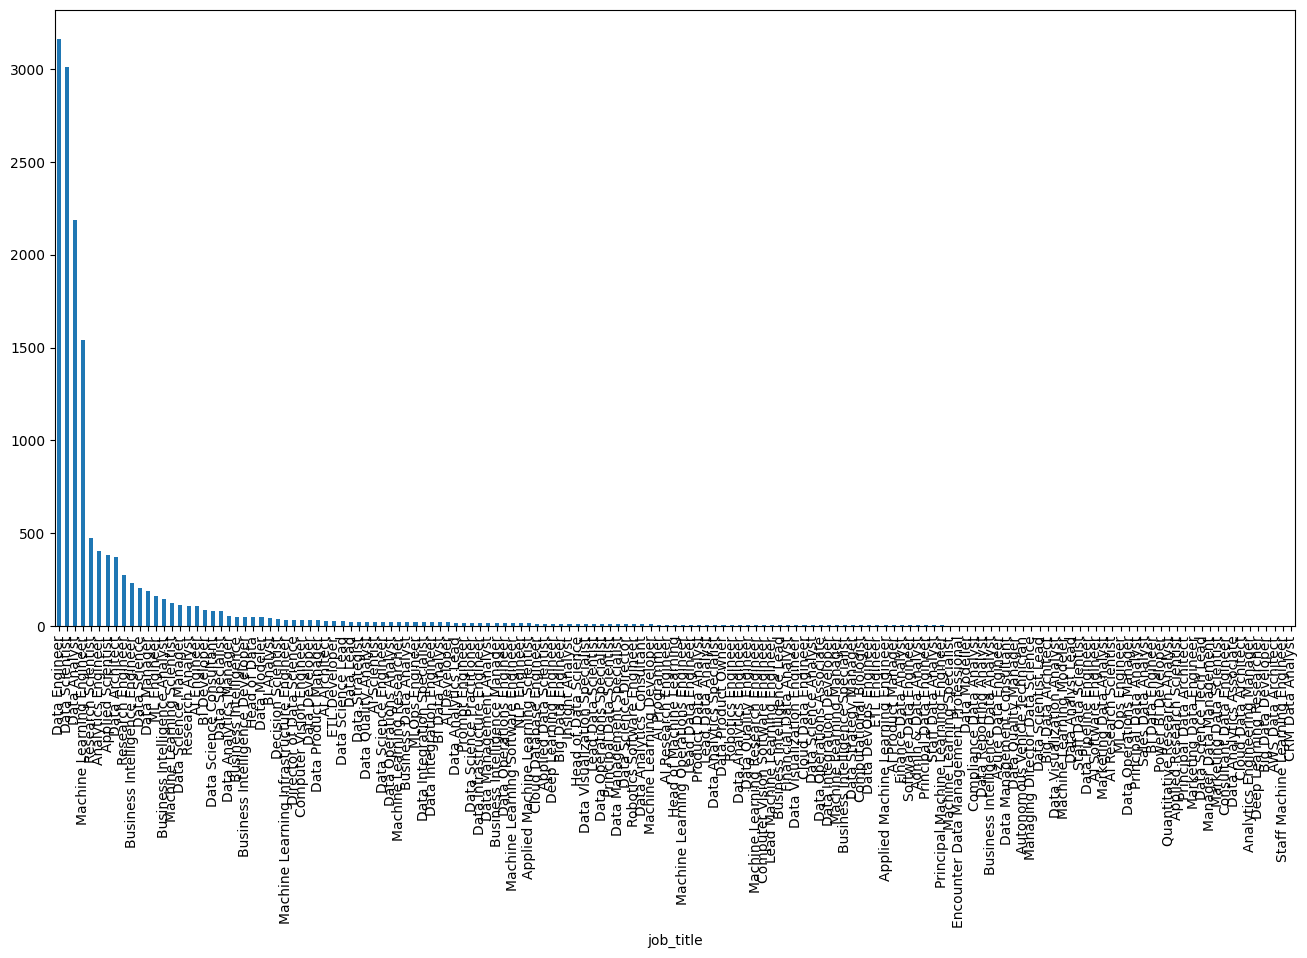

In [ ]:
#@title Plotting the amount of entries for all job titles

df['job_title'].value_counts().plot(kind='bar', figsize=(16,8), rot = 90)

<Axes: xlabel='job_title'>

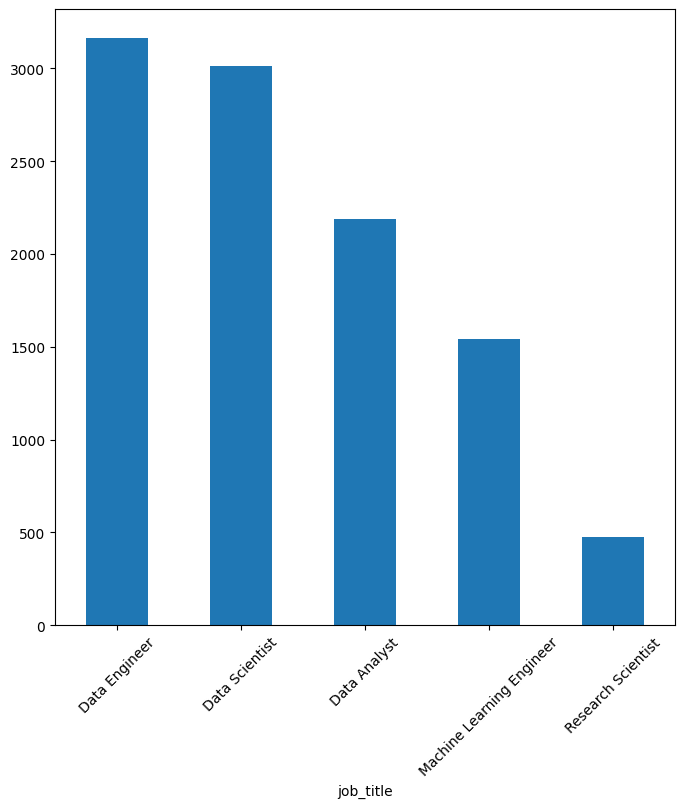

In [ ]:
#@title Plotting the top 4 most common job titles in the dataset

most_common_jobs = (df['job_title'].value_counts())[:5]

most_common_jobs.plot(kind='bar', figsize=(8,8), rot=45)

job_title
Analytics Engineering Manager     399880.000000
Data Science Tech Lead            375000.000000
Head of Machine Learning          299758.428571
Managing Director Data Science    280000.000000
AWS Data Architect                258000.000000
                                      ...      
Admin & Data Analyst               50740.666667
Insight Analyst                    46459.916667
Compliance Data Analyst            45000.000000
CRM Data Analyst                   40000.000000
Principal Data Architect           38154.000000
Name: salary_in_usd, Length: 153, dtype: float64
job_title
Data Engineer                      3162
Data Scientist                     3015
Data Analyst                       2189
Machine Learning Engineer          1542
Research Scientist                  475
                                   ... 
Applied Research Scientist            1
Data Science Tech Lead                1
BI Data Engineer                      1
Big Data Developer                    1
Sta

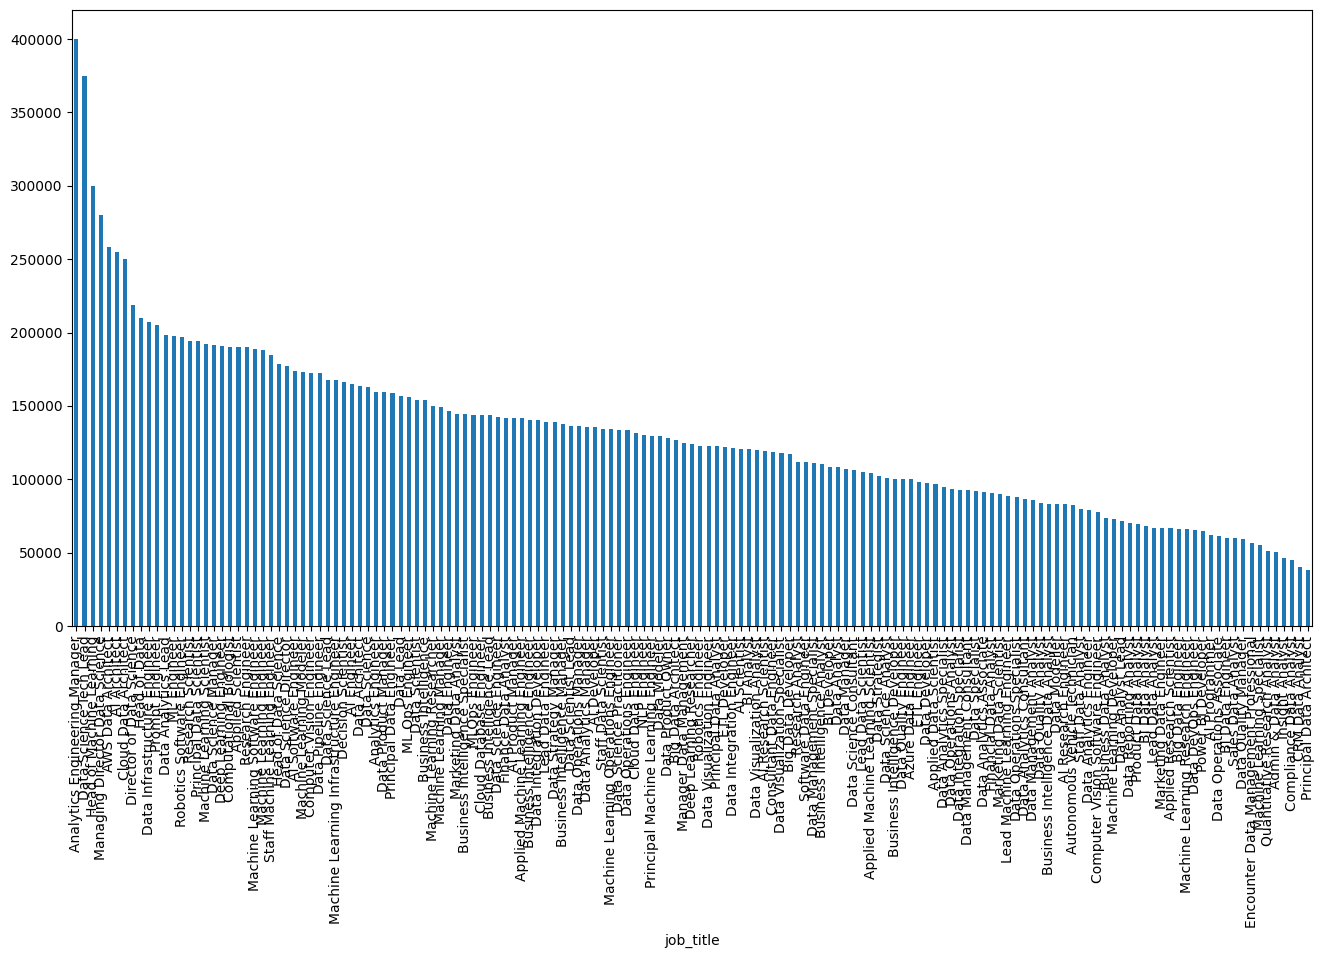

In [ ]:
#@title Printing and plottin all the job titles with average salaray_in_usd in descending order

df.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(16,8))

print(df.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False))
print(df.groupby('job_title')['salary_in_usd'].count().sort_values(ascending=False))

job_title
Analytics Engineering Manager     399880.000000
Data Science Tech Lead            375000.000000
Head of Machine Learning          299758.428571
Managing Director Data Science    280000.000000
AWS Data Architect                258000.000000
AI Architect                      255142.357143
Cloud Data Architect              250000.000000
Director of Data Science          218775.333333
Head of Data                      210013.714286
Data Infrastructure Engineer      207332.812500
Name: salary_in_usd, dtype: float64


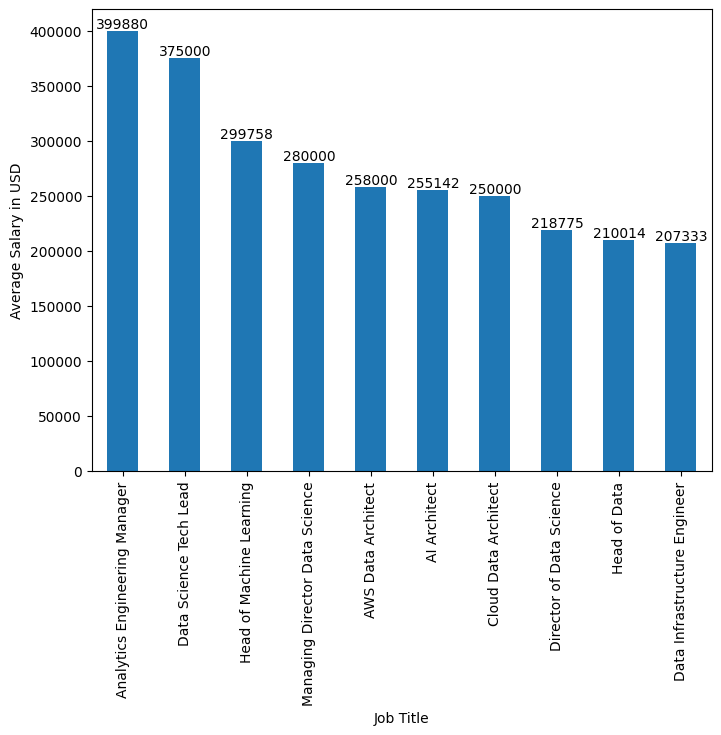

In [ ]:
#@title Plotting the 10 highest averaging salaray_in_usd job titles


highest_paid_jobs = df.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False)[:10]

ax = highest_paid_jobs.plot(kind='bar', figsize=(8,6))
ax.set_xlabel('Job Title')
ax.set_ylabel('Average Salary in USD')

for container in ax.containers:
  ax.bar_label(container)

print(highest_paid_jobs)

**Most of the job titles above have only a few entries in the dataset so will not be using them for the highest average salary comparison as there are not enough entries. The 5 most common job titles will be used for average salary comparison.**

## Graphs

### Job Title - Salary

Text(0.5, 0, 'Other Avg Salary 155876.19')

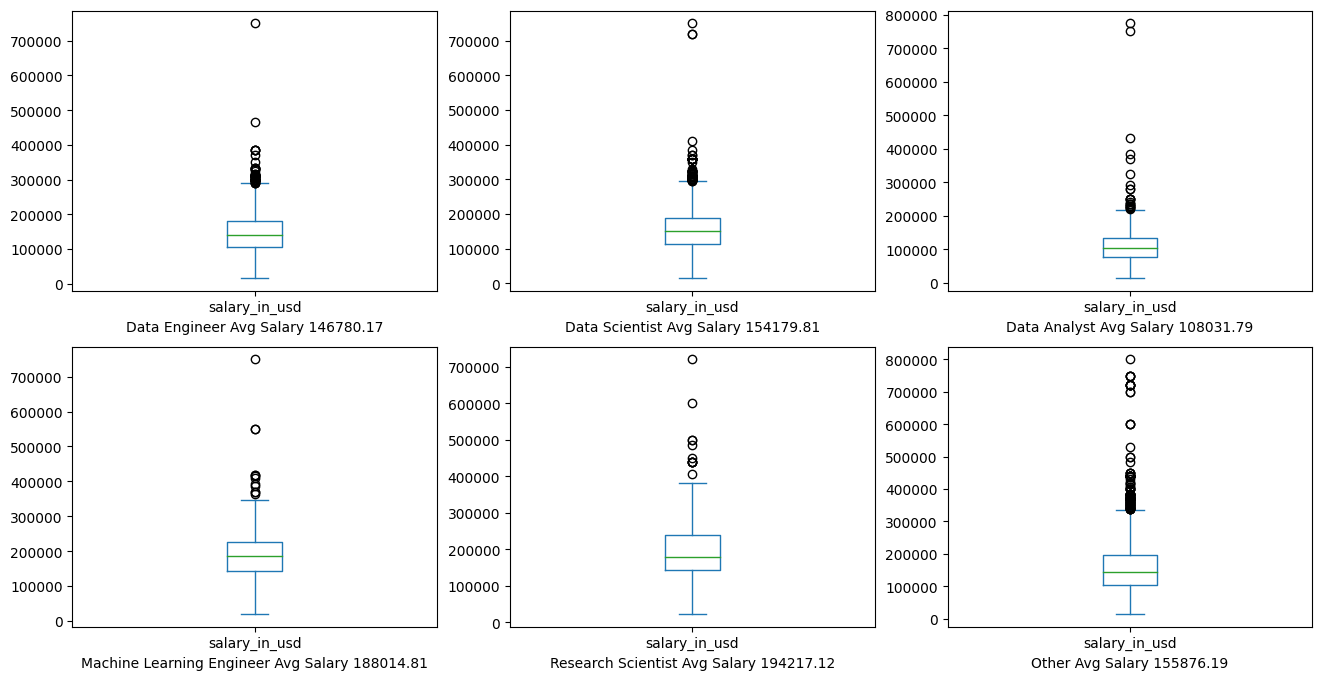

In [ ]:
#@title Boxplots of salary per job title

# Plotting the average salary for the 5 most common job titles and the average of all the other job titles.
fig, axs = plt.subplots(2, 3, figsize=(16,8))

# Plot for Averagy salary of Data Engineers
df.loc[df['job_title'] == 'Data Engineer']['salary_in_usd'].plot(kind='box', ax=axs[0,0],rot = 0)
axs[0,0].set_xlabel('Data Engineer Avg Salary ' + str(round(df.loc[df['job_title'] == 'Data Engineer']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of Data Scientists
df.loc[df['job_title'] == 'Data Scientist']['salary_in_usd'].plot(kind='box', ax=axs[0,1],rot = 0)
axs[0,1].set_xlabel('Data Scientist Avg Salary ' + str(round(df.loc[df['job_title'] == 'Data Scientist']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of Data Analysts
df.loc[df['job_title'] == 'Data Analyst']['salary_in_usd'].plot(kind='box', ax=axs[0,2],rot = 0)
axs[0,2].set_xlabel('Data Analyst Avg Salary ' + str(round(df.loc[df['job_title'] == 'Data Analyst']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of Machine Learning Engineers
df.loc[df['job_title'] == 'Machine Learning Engineer']['salary_in_usd'].plot(kind='box', ax=axs[1,0],rot = 0)
axs[1,0].set_xlabel('Machine Learning Engineer Avg Salary ' + str(round(df.loc[df['job_title'] == 'Machine Learning Engineer']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of Research Scientists
df.loc[df['job_title'] == 'Research Scientist']['salary_in_usd'].plot(kind='box', ax=axs[1,1],rot = 0)
axs[1,1].set_xlabel('Research Scientist Avg Salary ' + str(round(df.loc[df['job_title'] == 'Research Scientist']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of every other job title, besides the ones plotted above
df.loc[(df['job_title'] != 'Data Engineer') & (df['job_title'] != 'Data Scientist') &
       (df['job_title'] != 'Data Analyst') & (df['job_title'] != 'Machine Learning Engineer')]['salary_in_usd'].plot(kind='box', ax=axs[1,2],rot = 0)
axs[1,2].set_xlabel('Other Avg Salary ' + str(round(df.loc[(df['job_title'] != 'Data Engineer') & (df['job_title'] != 'Data Scientist') &
       (df['job_title'] != 'Data Analyst') & (df['job_title'] != 'Machine Learning Engineer')]['salary_in_usd'].mean(), 2)))

**As we can see from the sixth graph, there are a lot of instances where high averaging salary jobs contain jobs that only appear few times, so they are not representative of the overall salary range.**

Text(0.5, 0, 'Other Avg Salary 152197.67')

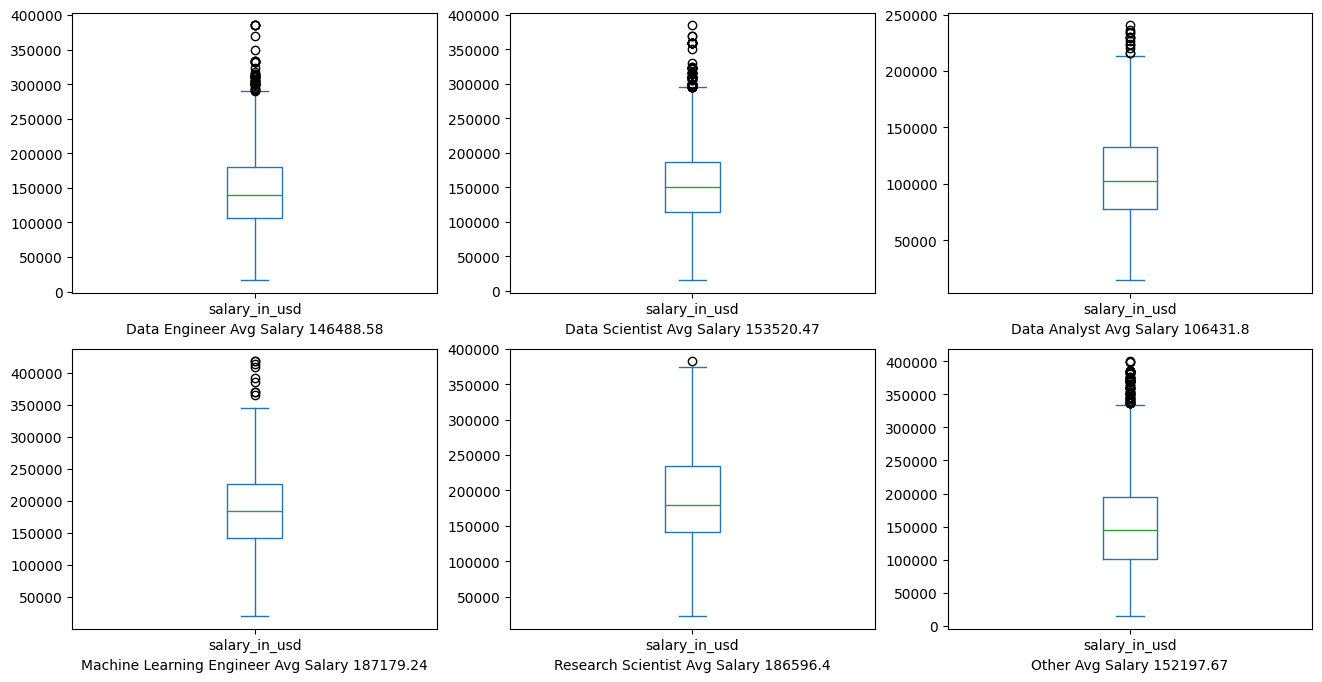

In [ ]:
#@title Salary boxplots per job title, without outliers

# Removing salary outliers from each job title and plotting the boxplots again.
df.drop(df[(df['job_title'] == 'Data Engineer') & (df['salary_in_usd'] >= 400000)].index, inplace=True)
df.drop(df[(df['job_title'] == 'Data Scientist') & (df['salary_in_usd'] >= 400000)].index, inplace=True)
df.drop(df[(df['job_title'] == 'Data Analyst') & (df['salary_in_usd'] >= 250000)].index, inplace=True)
df.drop(df[(df['job_title'] == 'Machine Learning Engineer') & (df['salary_in_usd'] >= 500000)].index, inplace=True)
df.drop(df[(df['job_title'] == 'Research Scientist') & (df['salary_in_usd'] >= 550000)].index, inplace=True)
df.drop(df[((df['job_title'] != 'Data Engineer') & (df['job_title'] != 'Data Scientist') & (df['job_title'] != 'Data Analyst') & (df['job_title'] != 'Machine Learning Engineer')) & (df['salary_in_usd'] >= 400000)].index, inplace=True)


fig, axs = plt.subplots(2, 3, figsize=(16,8))

# Plot for Averagy salary of Data Engineers
df.loc[df['job_title'] == 'Data Engineer']['salary_in_usd'].plot(kind='box', ax=axs[0,0],rot = 0)
axs[0,0].set_xlabel('Data Engineer Avg Salary ' + str(round(df.loc[df['job_title'] == 'Data Engineer']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of Data Scientists
df.loc[df['job_title'] == 'Data Scientist']['salary_in_usd'].plot(kind='box', ax=axs[0,1],rot = 0)
axs[0,1].set_xlabel('Data Scientist Avg Salary ' + str(round(df.loc[df['job_title'] == 'Data Scientist']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of Data Analysts
df.loc[df['job_title'] == 'Data Analyst']['salary_in_usd'].plot(kind='box', ax=axs[0,2],rot = 0)
axs[0,2].set_xlabel('Data Analyst Avg Salary ' + str(round(df.loc[df['job_title'] == 'Data Analyst']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of Machine Learning Engineers
df.loc[df['job_title'] == 'Machine Learning Engineer']['salary_in_usd'].plot(kind='box', ax=axs[1,0],rot = 0)
axs[1,0].set_xlabel('Machine Learning Engineer Avg Salary ' + str(round(df.loc[df['job_title'] == 'Machine Learning Engineer']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of Research Scientists
df.loc[df['job_title'] == 'Research Scientist']['salary_in_usd'].plot(kind='box', ax=axs[1,1],rot = 0)
axs[1,1].set_xlabel('Research Scientist Avg Salary ' + str(round(df.loc[df['job_title'] == 'Research Scientist']['salary_in_usd'].mean(), 2)))

# Plot for Averagy salary of every other job title, besides the ones plotted above
df.loc[(df['job_title'] != 'Data Engineer') & (df['job_title'] != 'Data Scientist') &
       (df['job_title'] != 'Data Analyst') & (df['job_title'] != 'Machine Learning Engineer')]['salary_in_usd'].plot(kind='box', ax=axs[1,2],rot = 0)
axs[1,2].set_xlabel('Other Avg Salary ' + str(round(df.loc[(df['job_title'] != 'Data Engineer') & (df['job_title'] != 'Data Scientist') &
       (df['job_title'] != 'Data Analyst') & (df['job_title'] != 'Machine Learning Engineer')]['salary_in_usd'].mean(), 2)))

### Year - Salary of top 5 Jobs

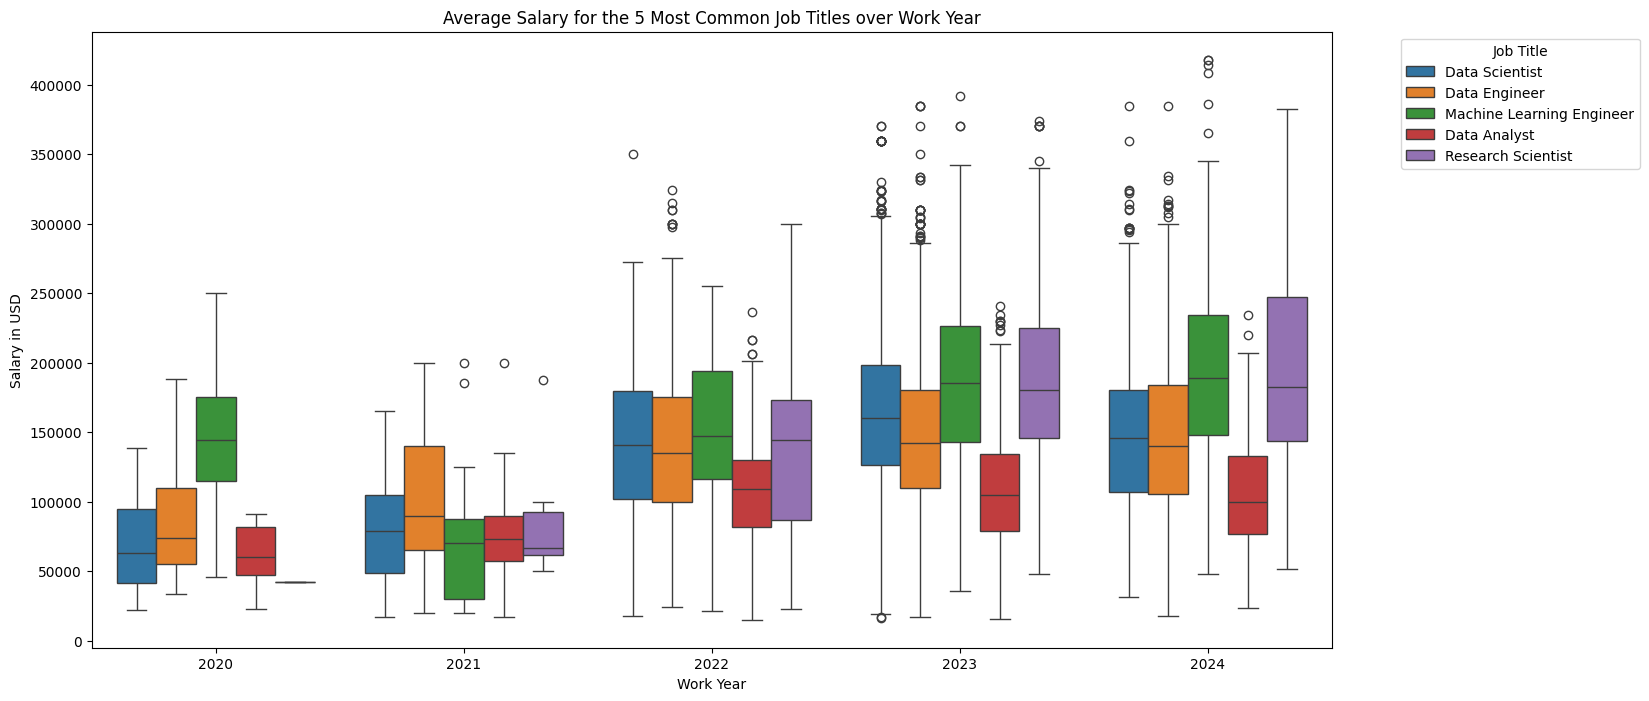

In [ ]:
#@title Plotting average salary for the 5 most common job titles over work_year

# Filter the DataFrame to include only the 5 most common job titles
top_5_job_titles = df['job_title'].value_counts().nlargest(5).index
df_top_5 = df[df['job_title'].isin(top_5_job_titles)]

# Plotting average salary for the 5 most common job titles over work_year
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_top_5, x='work_year', y='salary_in_usd', hue='job_title')
plt.title('Average Salary for the 5 Most Common Job Titles over Work Year')
plt.xlabel('Work Year')
plt.ylabel('Salary in USD')
plt.legend(title='Job Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Remote work - Salary of top 5 jobs

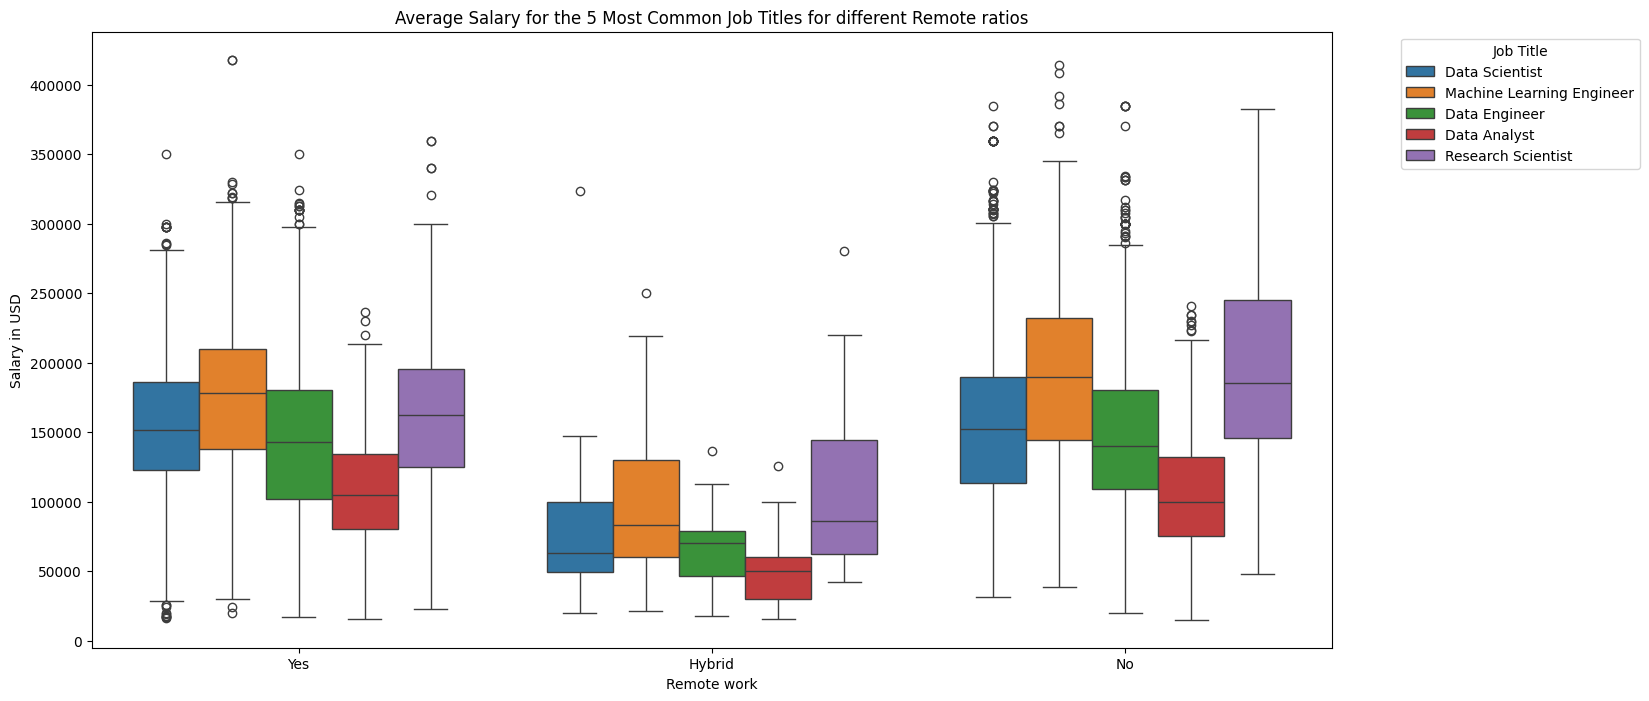

In [ ]:
#@title Plotting average salary for the remote_work categories over work_year
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_top_5, x='remote_work', y='salary_in_usd', hue='job_title')
plt.title('Average Salary for the 5 Most Common Job Titles for different Remote ratios')
plt.xlabel('Remote work')
plt.ylabel('Salary in USD')
plt.legend(title='Job Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Experience level - Salary of top 5 Jobs

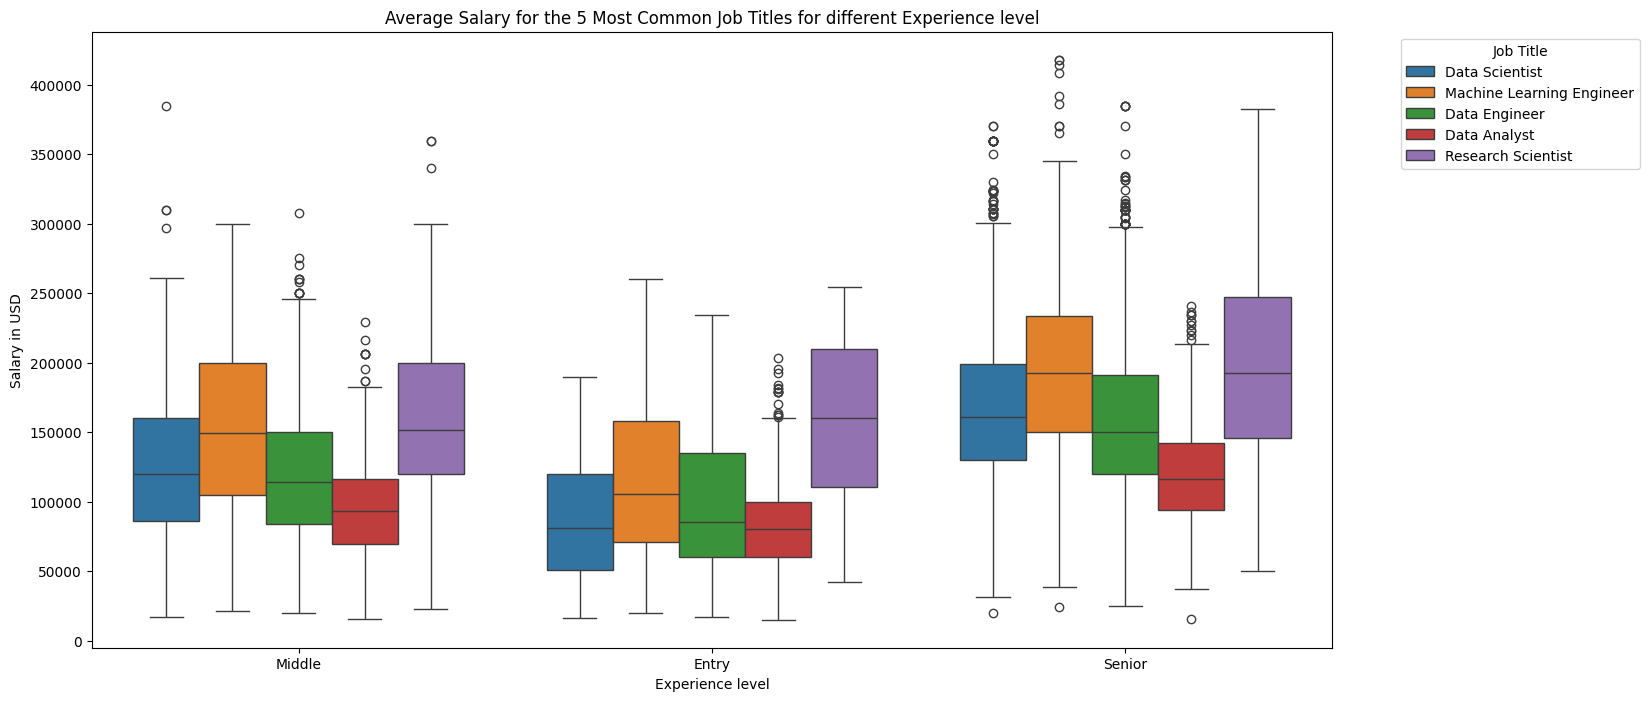

In [ ]:
#@title Plotting average salary for the experience level of the 5 most common job titles over work_year
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_top_5, x='experience_cat', y='salary_in_usd', hue='job_title')
plt.title('Average Salary for the 5 Most Common Job Titles for different Experience level')
plt.xlabel('Experience level')
plt.ylabel('Salary in USD')
plt.legend(title='Job Title', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Models

## Data preparation

### Features & Target

In [ ]:
#@title Initial dataset after basic preprocessing

df

work_year  job_title  salary_in_usd  company_size  remote_work  salary  \
0           2021         89          40038             0            2     Low   
1           2021         21          36259             0            0     Low   
2           2020         89          35735             0            0     Low   
3           2021        114          77364             2            0  Medium   
4           2022        113          95386             0            0  Medium   
...          ...        ...            ...           ...          ...     ...   
14833       2022         31          15000             1            2     Low   
14834       2020        150          15000             1            1     Low   
14835       2021        117          15000             0            2     Low   
14836       2022         45          15000             0            1     Low   
14837       2020        114          15966             2            2     Low   

       company_loc  employee_loc  experience_cat  
0                1             1               1  
1                2             1               1  
2                1             1               1  
3                1             1               1  
4                1             1               2  
...            ...           ...             ...  
14833            1             1               1  
14834            1             1               2  
14835            1             1               0  
14836            1             1               0  
14837            1             1               0  

[14838 rows x 9 columns]

In [ ]:
#@title Dataset column information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   work_year       14838 non-null  int64 
 1   job_title       14838 non-null  int64 
 2   salary_in_usd   14838 non-null  int64 
 3   company_size    14838 non-null  int64 
 4   remote_work     14838 non-null  int64 
 5   salary          14838 non-null  object
 6   company_loc     14838 non-null  int64 
 7   employee_loc    14838 non-null  int64 
 8   experience_cat  14838 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 1.0+ MB


In [ ]:
#@title Encoding categorical values using LabelEncoder, except the salary column.


# Using a second dataframe to store the mapped values from the label encoder for explainability.
df2 = pd.DataFrame()

labelencoder = LabelEncoder()

columns = df.columns.difference(['salary']) # Excluding the categorical salary column, as it will be converted manually

for col in columns:
    if df[col].dtype == "object" or df[col].dtype == "bool": #If the column type is 'object' or 'boolean' will encode into numerical

        df2[col] = df[col] # Copying the original values of the current column to the second dataframe
        print("{:<30}".format(col), ":", "{:<30}".format(str(df[col].dtype)) , "Formatting to LabelEncoding")
        df[col] = labelencoder.fit_transform(df[col]) # Copying the encoded values for the current column to the second dataframe
        df2[col+'_Mapped'] = df[col]
    else:
        print("{:<30}".format(col), ":", "{:<30}".format(str(df[col].dtype)) , "No formatting required.")
        df2[col] = df[col] # If the current column doesn't need encoding, it's being copied as is in the new dataframe

company_loc                    : int64                          No formatting required.
company_size                   : int64                          No formatting required.
employee_loc                   : int64                          No formatting required.
experience_cat                 : int64                          No formatting required.
job_title                      : int64                          No formatting required.
remote_work                    : int64                          No formatting required.
salary_in_usd                  : int64                          No formatting required.
work_year                      : int64                          No formatting required.


In [ ]:
#@title Dataset with the mapping of original and labelled values for categorical values

df2.head(50)

company_loc  company_size  employee_loc  experience_cat  job_title  \
0             1             0             1               1         89   
1             2             0             1               1         21   
2             1             0             1               1         89   
3             1             2             1               1        114   
4             1             0             1               2        113   
5             1             2             1               1        114   
6             1             0             1               2         86   
7             1             1             1               0         89   
8             1             0             1               2        108   
9             1             0             1               0        144   
10            1             0             1               1        107   
11            1             2             1               0          4   
12            1             0             1               2        118   
13            1             0             1               2        112   
14            1             2             1               0         56   
15            1             0             1               1         89   
16            1             0             1               0         15   
17            1             0             1               2         89   
18            2             0             1               2         86   
19            1             0             1               2         86   
20            1             0             1               1        110   
21            1             0             1               1         86   
22            1             1             1               1         51   
23            1             0             1               2         60   
24            1             0             1               2        136   
25            1             0             1               2        112   
26            1             0             1               1         89   
27            1             0             1               1         56   
28            1             1             1               1        133   
29            2             1             1               1         89   
30            1             1             1               1         89   
31            1             2             1               1         15   
32            1             0             1               1         89   
33            1             0             1               1         26   
34            1             0             1               0         56   
35            1             0             1               0         89   
36            1             1             1               0         89   
37            1             0             1               0          5   
38            1             0             1               1        126   
39            1             1             1               0         89   
40            1             0             1               2        118   
41            1             0             1               0         45   
42            1             0             1               1         13   
43            1             0             1               1         26   
44            1             0             1               1        118   
45            1             1             1               0         56   
46            1             0             1               2          7   
47            1             0             1               1        110   
48            1             0             1               1        110   
49            1             1             1               1         50   

    remote_work  salary_in_usd  work_year  
0             2          40038       2021  
1             0          36259       2021  
2             0          35735       2020  
3             0          77364       2021  
4        

In [ ]:
print(df2.loc[df2['employee_loc'] == 'US'])
print(df2.loc[df2['employee_loc'] == 'GB'])

Empty DataFrame
Columns: [company_loc, company_size, employee_loc, experience_cat, job_title, remote_work, salary_in_usd, work_year]
Index: []
Empty DataFrame
Columns: [company_loc, company_size, employee_loc, experience_cat, job_title, remote_work, salary_in_usd, work_year]
Index: []


In [ ]:
"""

#@title Manually mapping and converting salary categories to 0 as 'Low', 2 as 'Medium' and 4 as 'High'


# Converting string values to non-consecutive values
df['salary'] = df['salary'].replace({'Low' : 0,
                     'Medium': 2,
                     'High': 4})
print(df.head(5))
"""

"\n\n#@title Manually mapping and converting salary categories to 0 as 'Low', 2 as 'Medium' and 4 as 'High'\n\n\n# Converting string values to non-consecutive values\ndf['salary'] = df['salary'].replace({'Low' : 0,\n                     'Medium': 2,\n                     'High': 4})\nprint(df.head(5))\n"

In [ ]:
#@title Final dataset before reordering of columns

df.head(5)

work_year  job_title  salary_in_usd  company_size  remote_work  salary  \
0       2021         89          40038             0            2     Low   
1       2021         21          36259             0            0     Low   
2       2020         89          35735             0            0     Low   
3       2021        114          77364             2            0  Medium   
4       2022        113          95386             0            0  Medium   

   company_loc  employee_loc  experience_cat  
0            1             1               1  
1            2             1               1  
2            1             1               1  
3            1             1               1  
4            1             1               2

In [ ]:
#@title Reordering columns so that the salary feature is last

new_cols = [col for col in df.columns if col != 'salary'] + ['salary']
df_final = df.copy()
df_final = df_final[new_cols]


# Dropping the original 'salary_in_usd' column since it has been converted into the 'salary' column for prediction
df_final.drop(['salary_in_usd'], axis = 1, inplace = True)

df_final.head(5)


work_year  job_title  company_size  remote_work  company_loc  employee_loc  \
0       2021         89             0            2            1             1   
1       2021         21             0            0            2             1   
2       2020         89             0            0            1             1   
3       2021        114             2            0            1             1   
4       2022        113             0            0            1             1   

   experience_cat  salary  
0               1     Low  
1               1     Low  
2               1     Low  
3               1  Medium  
4               2  Medium

In [ ]:
#@title Splitting the data into train and test subsets

# Convert to array
array = df_final.values

# get seperated input and classifies, using a deep copy of a list
X = array[:,0:7]
Y = array[:,7]

scaler = preprocessing.Normalizer().fit(X)
normalizedX = scaler.transform(X)


np.random.seed(1)
trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(normalizedX, Y, train_size=0.80)

## Decision Tree

### Build

In [ ]:
#@title Define and fit Decision Tree

model = DecisionTreeClassifier()

model.fit(trainX,trainY)


DecisionTreeClassifier()

In [ ]:
#@title Visualization of the decision tree

text_representation = tree.export_text(model)
print(text_representation)

|--- feature_6 <= 1.50
|   |--- feature_5 <= 1.50
|   |   |--- feature_6 <= 0.50
|   |   |   |--- feature_1 <= 117.50
|   |   |   |   |--- feature_3 <= 1.50
|   |   |   |   |   |--- feature_1 <= 86.50
|   |   |   |   |   |   |--- feature_3 <= 0.50
|   |   |   |   |   |   |   |--- feature_1 <= 1.50
|   |   |   |   |   |   |   |   |--- class: Medium
|   |   |   |   |   |   |   |--- feature_1 >  1.50
|   |   |   |   |   |   |   |   |--- feature_2 <= 1.50
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 2021.50
|   |   |   |   |   |   |   |   |   |   |--- feature_1 <= 69.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- feature_1 >  69.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: Medium
|   |   |   |   |   |   |   |   |   |--- feature_0 >  2021.50
|   |   |   |   |   |   |   |   |   |   |--- feature_1 <= 10.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |  

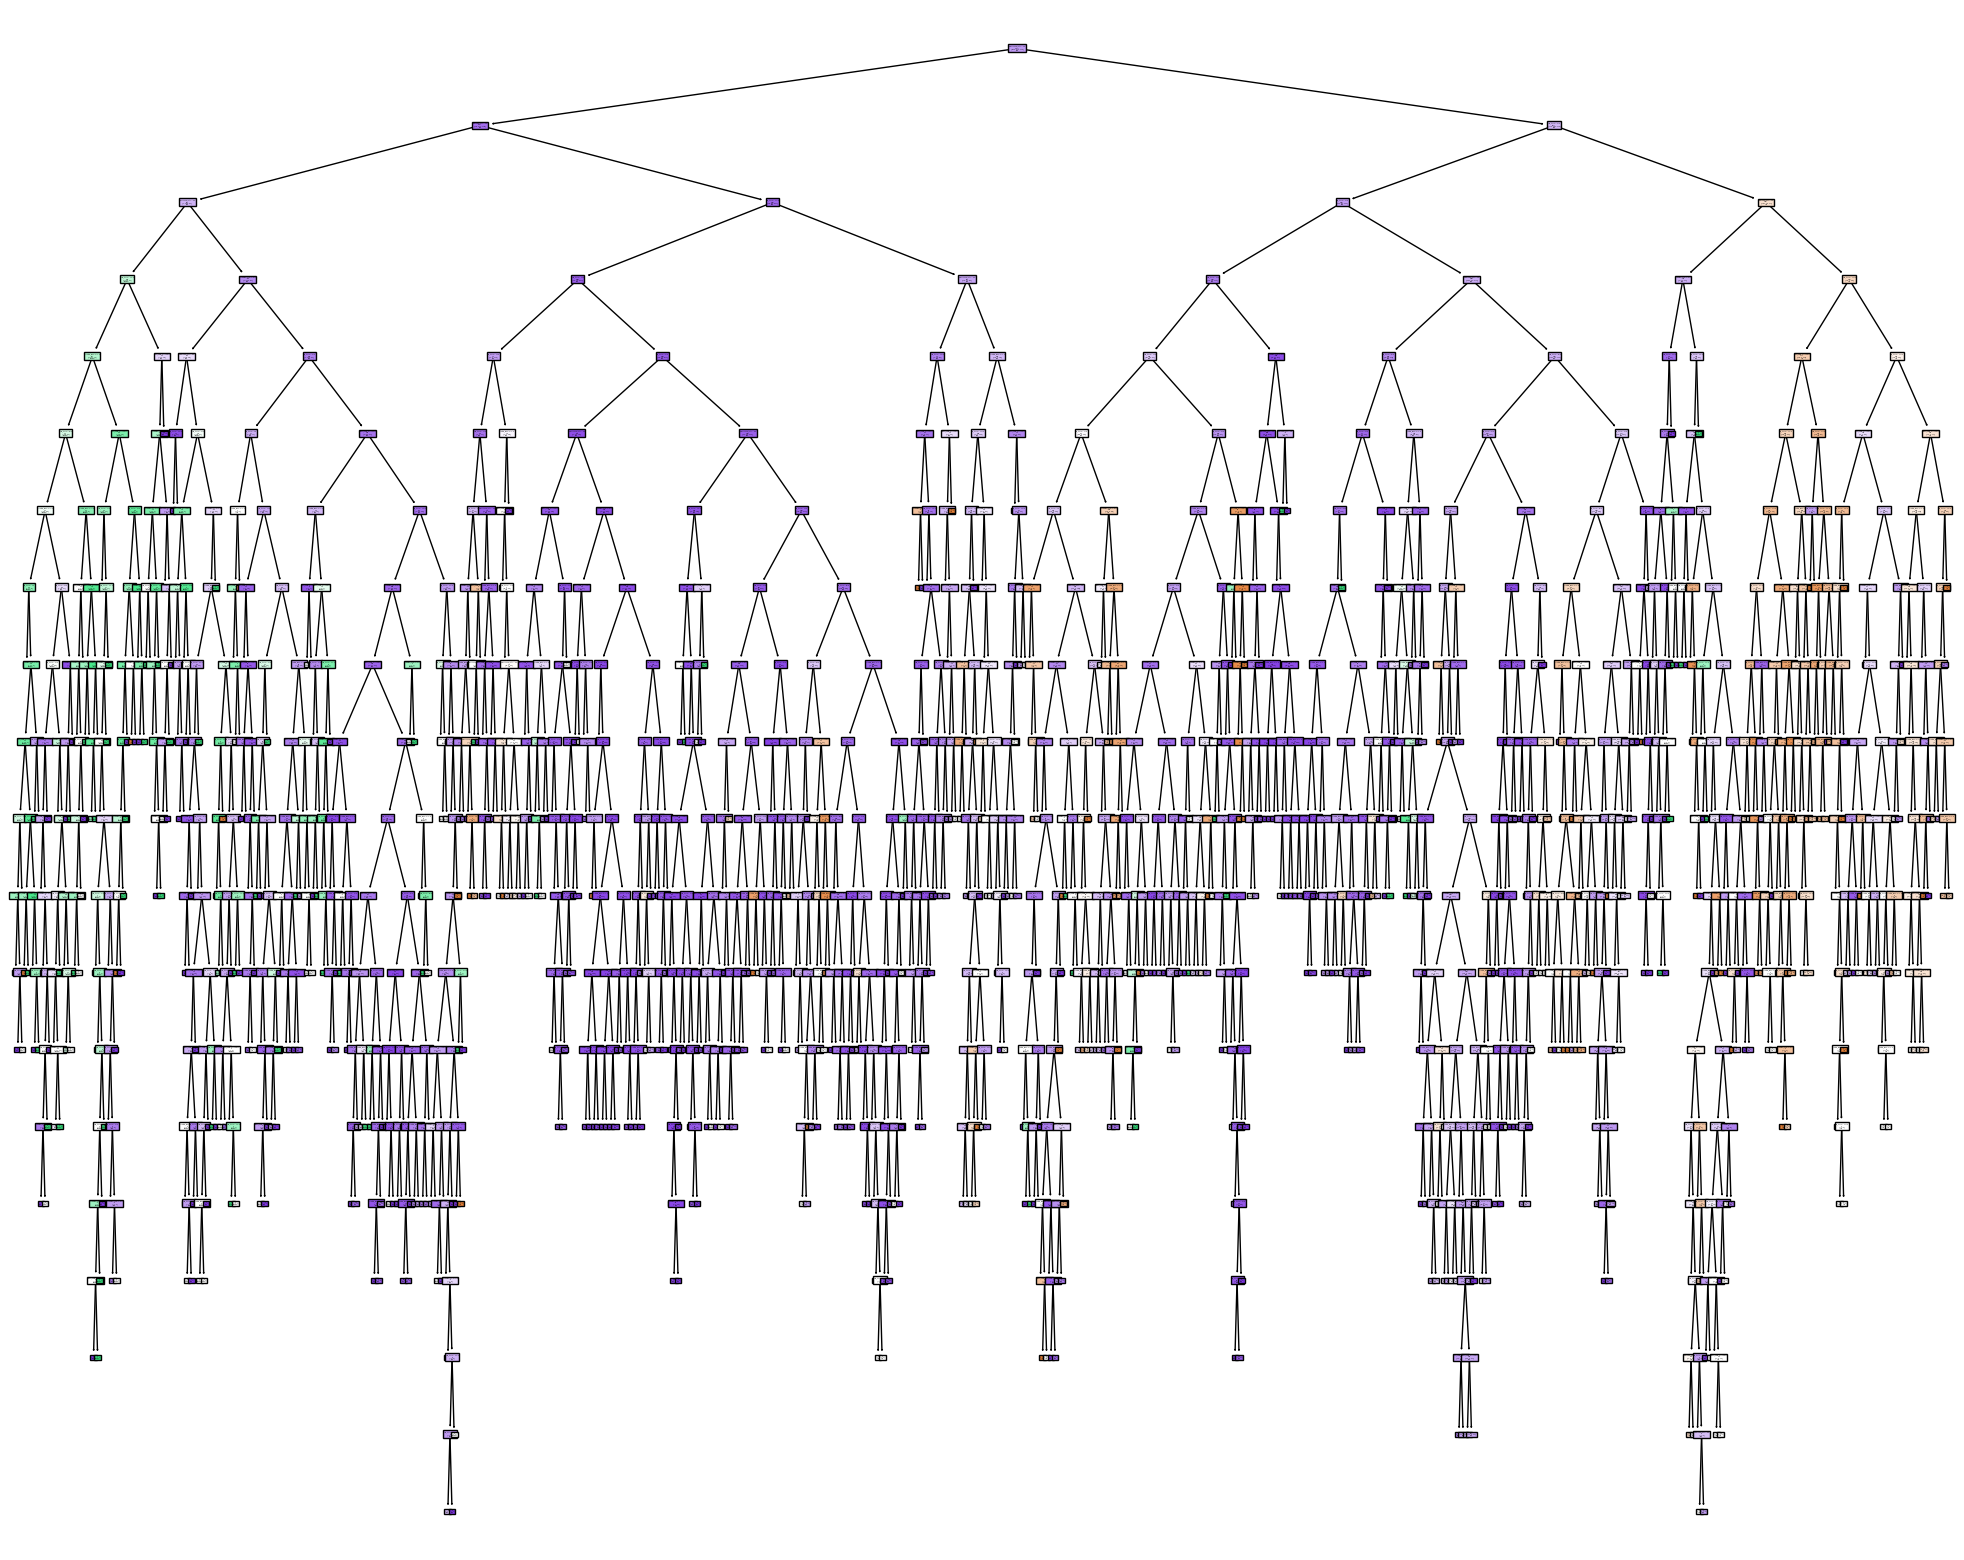

In [ ]:
#@title Graphical visualization of the full decision tree


colNames = df_final.columns.tolist()

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model,
                   feature_names=colNames,
                   class_names=model.classes_,
                   filled=True,
                   impurity=False, label=None)




### Metrics

In [ ]:
#@title Accuracy results of Decision Tree, without max_depth value

results = model.score(testX,testY)

print("Accuracy", round(results*100,2), "%")

Accuracy 68.43 %


## Decision Tree with Max Depth 3

In [ ]:
#@title Define and fit Decision Tree

model = DecisionTreeClassifier(max_depth=2)

model.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=2)

In [ ]:
#@title Visualization of the decision tree

text_representation = tree.export_text(model)
print(text_representation)

|--- feature_6 <= 1.50
|   |--- feature_5 <= 1.50
|   |   |--- class: Medium
|   |--- feature_5 >  1.50
|   |   |--- class: Medium
|--- feature_6 >  1.50
|   |--- feature_1 <= 96.50
|   |   |--- class: Medium
|   |--- feature_1 >  96.50
|   |   |--- class: High



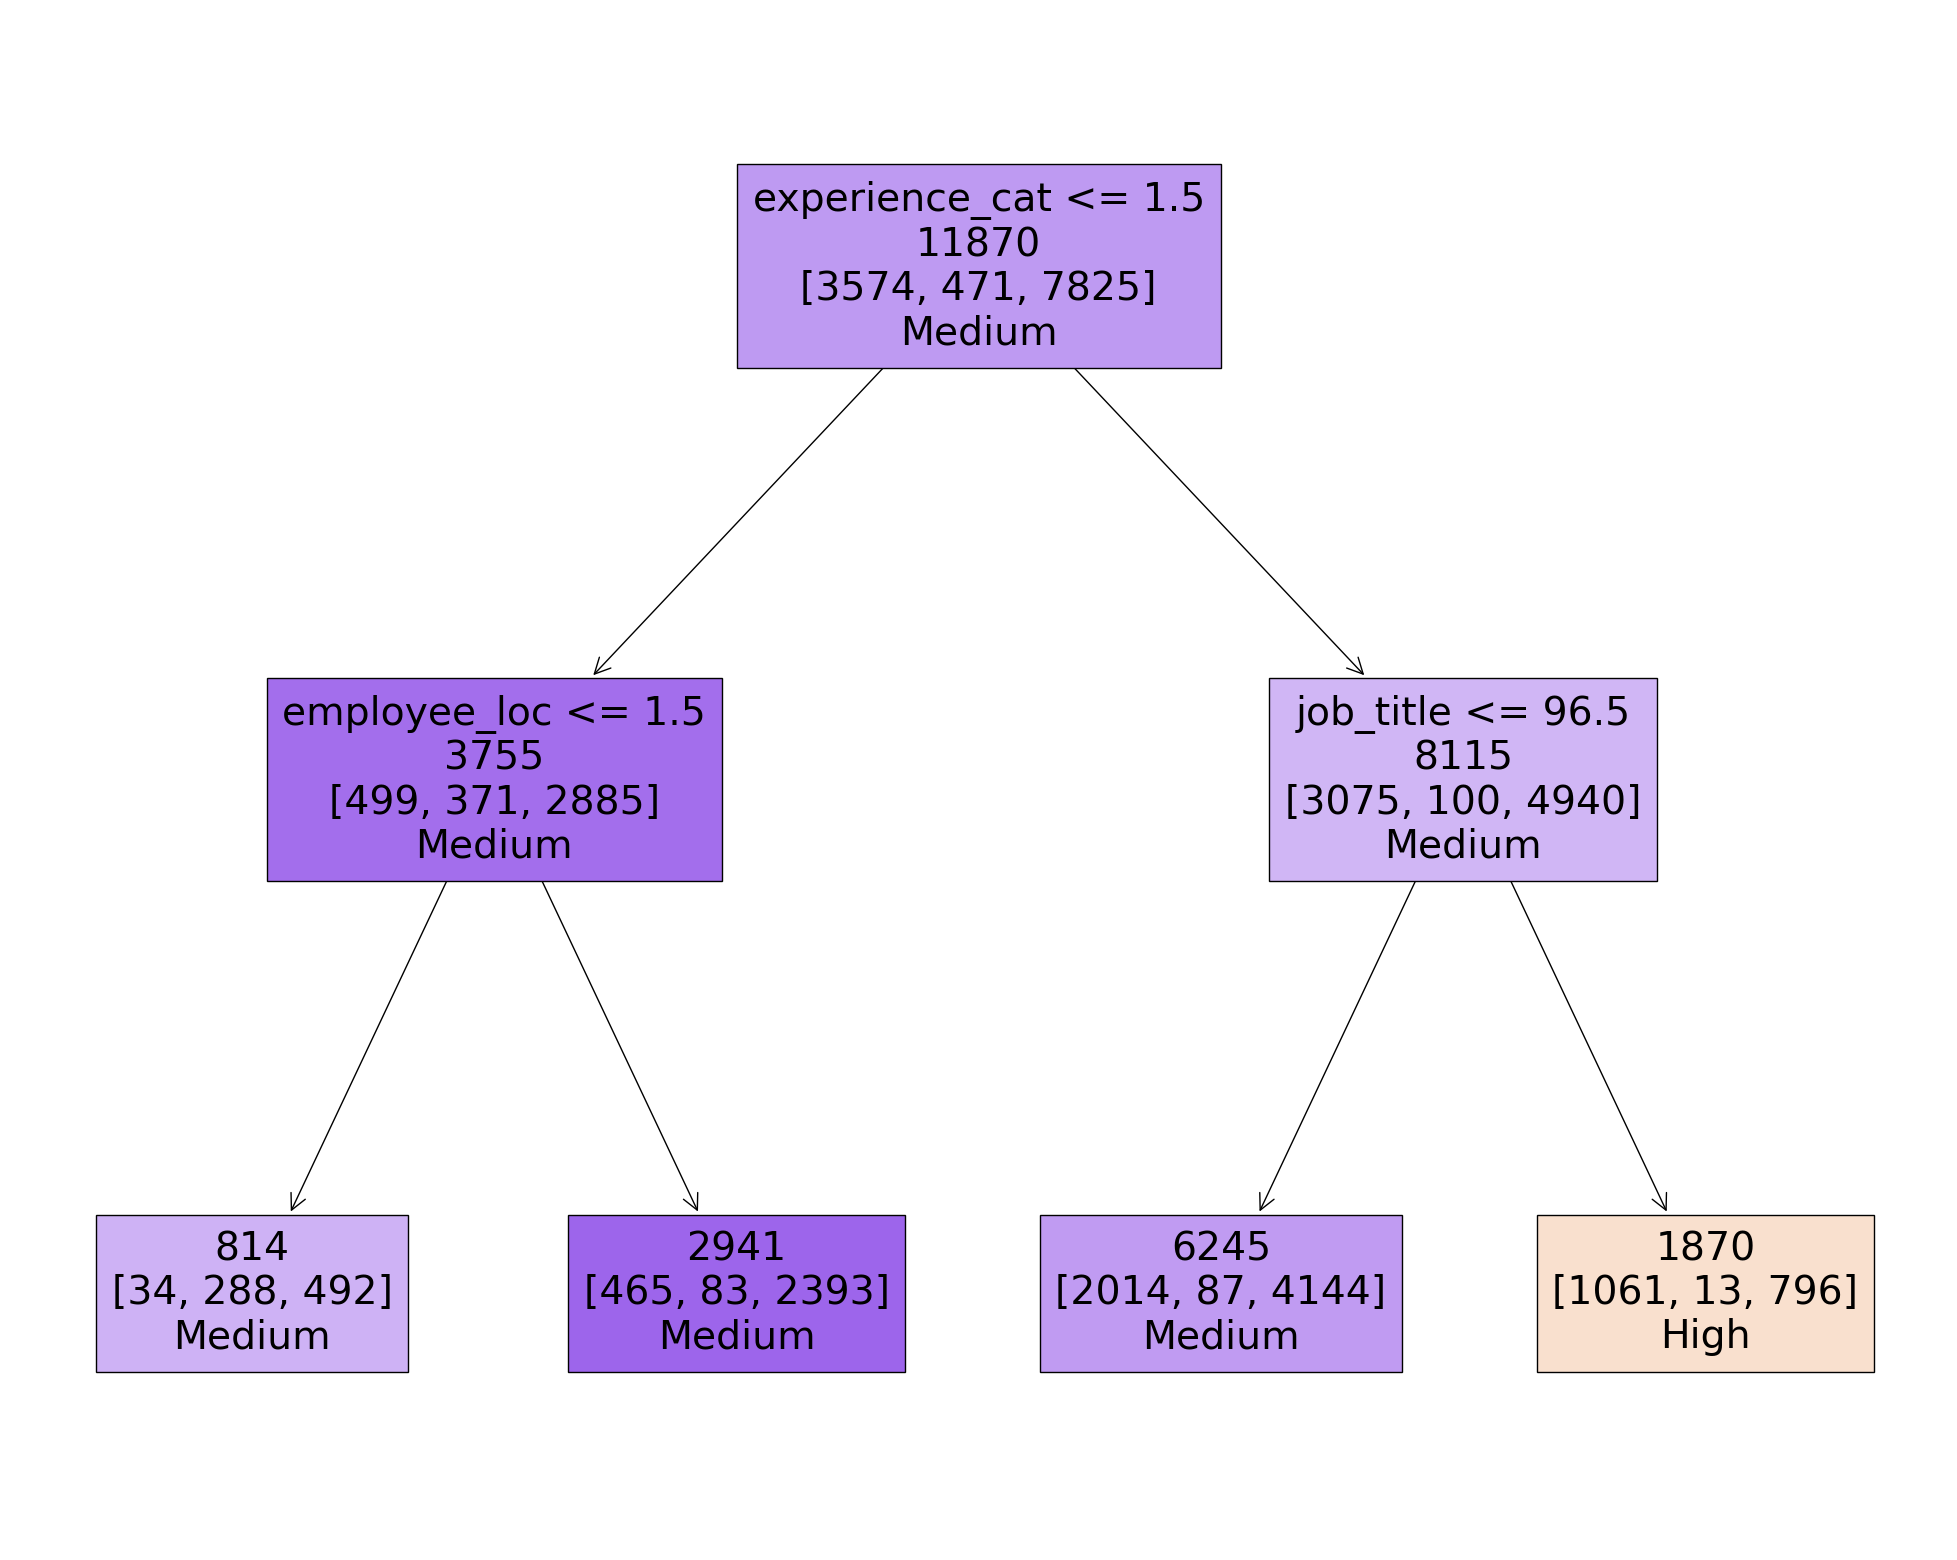

In [ ]:
#@title Graphical visualization of the full decision tree

colNames = df_final.columns.tolist()


fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model,
                   feature_names=colNames,
                   class_names=model.classes_,
                   filled=True,
                   impurity=False, label=None)


### Metrics

In [ ]:
#@title Accuracy results of Decision Tree, with max_depth value 3

results = model.score(testX,testY)

print("Accuracy", round(results*100,2), "%")

Accuracy 68.67 %


## EBM - Decision Tree

In [ ]:
#@title EBM build

ebm = ExplainableBoostingClassifier()
ebm.fit(trainX, trainY)

ExplainableBoostingClassifier()

In [ ]:
#@title EBM accuracy

results = ebm.score(testX,testY)

print("Accuracy", round(results*100,2), "%")

Accuracy 69.68 %


In [ ]:
#@title EBM results

ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
#@title Most important features using Explainable Boosting Machines

print('Most important feature using EBM - Decision Tree ', df.columns[1])
print('Second most important feature using EBM - Decision Tree ', df.columns[6])

Most important feature using EBM - Decision Tree  job_title
Second most important feature using EBM - Decision Tree  company_loc


## Neural Network

### Target value mapping

In [ ]:
# Mapping current categories to consecutive integers
label_map = {'Low': 0, 'Medium': 1, 'High': 2}

# Apply the mapping to your original labels
Y_mapped = [label_map[label] for label in Y]
trainY_mapped = [label_map[label] for label in trainY]
testY_mapped = [label_map[label] for label in testY]

# Perform one-hot encoding
Y_total = to_categorical(Y_mapped, num_classes=3)
Y_train = to_categorical(trainY_mapped, num_classes=3)
Y_test = to_categorical(testY_mapped, num_classes=3)

### Network Topology

Epoch 1/50
739/739 - 3s - loss: 16.8998 - acc: 0.5301 - 3s/epoch - 3ms/step
Epoch 2/50
739/739 - 2s - loss: 9.6564 - acc: 0.5305 - 2s/epoch - 2ms/step
Epoch 3/50
739/739 - 2s - loss: 5.1729 - acc: 0.5351 - 2s/epoch - 3ms/step
Epoch 4/50
739/739 - 2s - loss: 3.4602 - acc: 0.5438 - 2s/epoch - 3ms/step
Epoch 5/50
739/739 - 2s - loss: 2.5247 - acc: 0.5532 - 2s/epoch - 2ms/step
Epoch 6/50
739/739 - 1s - loss: 1.7807 - acc: 0.5534 - 1s/epoch - 2ms/step
Epoch 7/50
739/739 - 1s - loss: 1.2237 - acc: 0.5681 - 1s/epoch - 2ms/step
Epoch 8/50
739/739 - 2s - loss: 0.9184 - acc: 0.6020 - 2s/epoch - 2ms/step
Epoch 9/50
739/739 - 1s - loss: 0.7704 - acc: 0.6480 - 1s/epoch - 2ms/step
Epoch 10/50
739/739 - 1s - loss: 0.7364 - acc: 0.6590 - 980ms/epoch - 1ms/step
Epoch 11/50
739/739 - 1s - loss: 0.7228 - acc: 0.6655 - 980ms/epoch - 1ms/step
Epoch 12/50
739/739 - 1s - loss: 0.7155 - acc: 0.6681 - 1s/epoch - 1ms/step
Epoch 13/50
739/739 - 1s - loss: 0.7053 - acc: 0.6663 - 1s/epoch - 2ms/step
Epoch 14/50
73

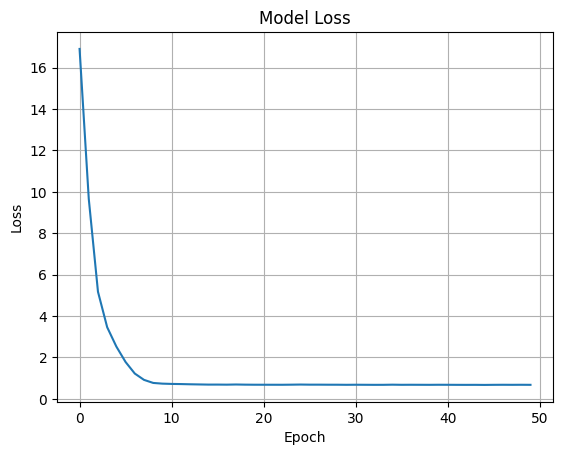

93/93 [==============================] - 0s 1ms/step - loss: 0.6758 - acc: 0.6710
Accuracy:  0.6709546446800232



In [ ]:
#@title Initial network topology

seed=1
tf.random.set_seed(seed)

model = Sequential()

model.add(Dense(50, input_dim=7, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='sigmoid'))


model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['acc'])

results = model.fit(trainX, Y_train, epochs=50, batch_size=16, verbose=2) #start with small number of epochs to explore the network topology

plt.plot(results.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.show()

print("Accuracy: ", model.evaluate(testX,Y_test)[1])
print()

Different depths of the NN have been tested, and the hyperparameters tuned. Deeper architectures (both in number of layers and neurons) didn't show any significant improvement in the accuracy compared to the architecture here presented. The best activation function in the last layer is sigmoid function, and smaller batch sizes converge with smaller number of epochs.

### Hyperparameter Tuning

In [ ]:
#@title Checking for best NN model
np.random.seed(seed)
tf.random.set_seed(seed)

def gs_model(optimizerIn='adam', initIn='GlorotUniform'):
    model = Sequential()
    model.add(Dense(50, input_dim=7, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizerIn, metrics=['acc'])
    return model

model = KerasClassifier(build_fn=gs_model)

# Grid search parameters
optimizers = ['rmsprop', 'adam', 'sgd']
batches = [1, 16, 32, 64, 128]
inits = ['normal', 'uniform']
epochs = [200]

# Checkpointing
checkpoint = ModelCheckpoint("myBest.hdf5", monitor='acc', save_best_only=True, mode="max", verbose=1)
earlystopping = EarlyStopping(monitor="acc",patience= 5)
callbacks_list = [checkpoint, earlystopping]


param_grid = dict(optimizerIn=optimizers, epochs=epochs, batch_size=batches, initIn=inits)

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y_total, callbacks=callbacks_list)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Streaming output truncated to the last 5000 lines.
Epoch 52/200
357/370 [===========================>..] - ETA: 0s - loss: 0.6913 - acc: 0.6522
Epoch 52: acc did not improve from 0.82648
93/93 [==============================] - 0s 2ms/step - loss: 0.9849 - acc: 0.2810
Epoch 1/200
358/370 [============================>.] - ETA: 0s - loss: 13.4395 - acc: 0.4798
Epoch 1: acc did not improve from 0.82648
370/370 [==============================] - 2s 2ms/step - loss: 13.3256 - acc: 0.4808
Epoch 2/200
348/370 [===========================>..] - ETA: 0s - loss: 8.1964 - acc: 0.4895
Epoch 2: acc did not improve from 0.82648
370/370 [==============================] - 1s 2ms/step - loss: 8.1487 - acc: 0.4895
Epoch 3/200
358/370 [============================>.] - ETA: 0s - loss: 5.9307 - acc: 0.4806
Epoch 3: acc did not improve from 0.82648
370/370 [==============================] - 1s 2ms/step - loss: 5.9069 - acc: 0.4795
Epoch 4/200
354/370 [===========================>..] - ETA: 0s - loss: 4.45

**Best: 0.661870 using {'batch_size': 1, 'epochs': 200, 'initIn': 'normal', 'optimizerIn': 'rmsprop'}**

The hyperparameter investigation looks inconclusive, as several combinations lead to the same accuracy. The hyperparameters will be kept as they are.

### Final Model

In [ ]:
seed=123
tf.random.set_seed(seed)

model = Sequential()

model.add(Dense(50, input_dim=7, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='sigmoid'))


model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['acc'])

results = model.fit(trainX, Y_train, epochs=200, batch_size=16, verbose=0) #start with small number of epochs to explore the network topology

print("Accuracy: ", model.evaluate(testX,Y_test)[1])
print()

93/93 [==============================] - 0s 1ms/step - loss: 0.6478 - acc: 0.6728
Accuracy:  0.6728436946868896



# Lime and shap NN

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(testX, feature_names=df_final.columns[:-1], class_names=['Low', 'Medium', 'High'])

idx = 0  # Index of the sample
exp = explainer.explain_instance(testX[idx], model.predict, num_features=len(df_final.columns[:-1]))

exp.show_in_notebook(show_table=True)


157/157 [==============================] - 0s 2ms/step


In [ ]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
import numpy as np
from sklearn.model_selection import train_test_split

from interpret import show
from interpret.blackbox import ShapKernel

# Explain the model's predictions using SHAP
explainer = shap.KernelExplainer(model, trainX[:200])
shap_values = explainer(testX[:200])

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
df_final.columns[:-1]

Index(['work_year', 'job_title', 'company_size', 'remote_work', 'company_loc',
       'employee_loc', 'experience_cat'],
      dtype='object')

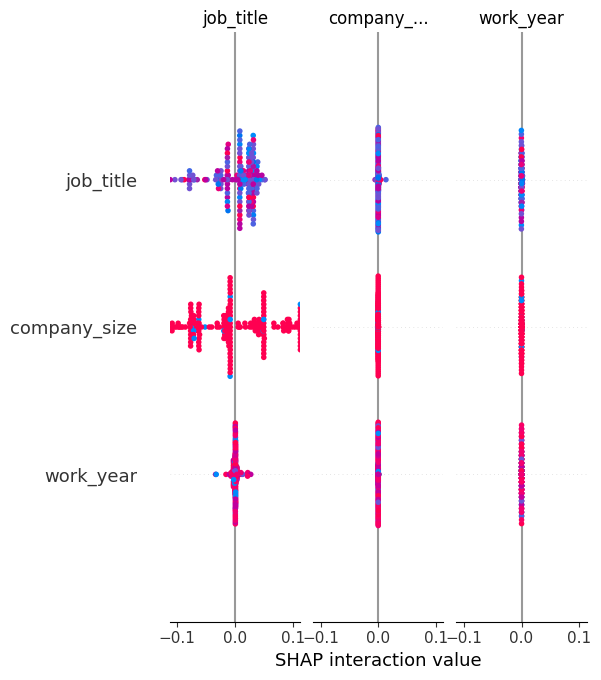

In [ ]:
shap.summary_plot(shap_values, trainX[:200], df_final.columns[:])

# Conclusion

**Evaluating the results of the best Neural Network model and the best Decision Tree we can see that their performance is very similar with the NN having an accuracy of 67%, while the DTC having higher accuracy with 70%.**

**In terms of explainability the Decision Tree, and using EBM, presents a much more explainable method of predicting the salary range.**

**On the other hand, the lime analysis reveals that the level of confidence of the NN model is very low, as it reaches only the 20% of prediction probability. This should be interpreted as a great limitation of the model developed.**

**The SHAP analysis reveals that the two main features in the classification are job_title and company_loc, accordingly with the EBM analysis.**

**Taking into consideration the similar performances, we can conclude that in this scenario a Decision Tree Classifier should be preferred as it provides a competitive performance when it comes to prediction accuracy, while still maintaining a lot of transparency and explainability.**